<a href="https://colab.research.google.com/github/JuanM-GG/Biologia-de-sistemas/blob/main/EWS_Tanaka2011_23Feb20_DOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Título: Tanaka model analysis

Nombre: Biología de sistemas

Fecha: Febrero 2021

In [ ]:
# instalar librerías
install.packages("deSolve")
install.packages("rootSolve")
install.packages("FME")

In [73]:
# cargar librerías
library(deSolve)
library(rootSolve)
library(FME)

In [74]:
# cargar Grind.R 
source("Grind.R")

grind.R was sourced


Artículo del que se generó la práctica 

Tanaka, R. J., Ono, M., & Harrington, H. A. (2011). Skin barrier homeostasis in atopic dermatitis: feedback regulation of kallikrein activity. PloS one, 6(5).



Como en el modelo de Chen, se hizp el análisis usando `Grind.R`. Primero, se transformó el modelo determinista en uno estocástico añadiendo ruido aditivo. Las funciones `run()` y el argumento `after`, permitieron hacer esto de manera sencilla 

In [75]:
# modelo empleado durante el análisis 
model <- function(t,state,parms){
        
  with(as.list(c(state,parms)),{
          
    dLK=  ka*Ka*L-kd*LK-dLK*LK
    
    dL = -ka*Ka*L+kd*LK-dL*L+tL*(mL+fLS*S+fL*Pa)
    
    dKa= -ka*Ka*L+kd*LK+k*Ka*K/(Ka+Ck)-dka*Ka
    
    dK= -k*Ka*K/(Ka+Ck)-dK*K+fKS*S+fK*Pa
    
    dP= -kp*Ka*P/(Ka+Cp)-dP*P+mP
    
    dPa=  kp*Ka*P/(Ka+Cp)-dPa*Pa
    
    return(list(c(dLK,dL,dKa,dK,dP,dPa)))
  })
}

In [76]:
# función para calcular la condición inicial dependiendo del valor del parámetro (S)
CondicionesInciales2 <- function(s_value, umbral_der, umbral_izq,Estado) {
        
  p = c(ka=1,kd=1,k=10,kp=10,dL=0.5,dK=1,dLK=1,dka=1,dP=0.5,dPa=0.5,tL=1,Ck=50,
        Cp=50,mP=10,mL=1,fKS=0.5,fLS=0.05,fK=0.4,fL=0.2, S = s_value)
  
  low <- newton(state=c(LK =0,L = 4, Ka = 0, K = 10, P = 20, Pa = 0), 
                parms = p, 
                odes = model,
                plot=F)
  hig <- newton(state=c(LK =6.4,L = 0.8, Ka = 16, K = 9.2, P = 3.4, Pa = 16.5),
                parms = p, 
                odes = model,
                plot=F);
  
  if (s_value < umbral_izq) {
          if(Estado == 0) {
                  IC <- c(low[1],low[2],low[3],low[4],low[5],low[6])
          } else if(Estado == 1) {
                  print("En esta región no hay biestabilidad")
                  IC <- c(low[1],low[2],low[3],low[4],low[5],low[6])
          }
  } else if(s_value >= umbral_izq & s_value <= umbral_der) {
          if(Estado == 0) {
                  IC<-c(low[1],low[2],low[3],low[4],low[5],low[6])
          } else if(Estado == 1) {
                  IC <- c(hig[1],hig[2],hig[3],hig[4],hig[5],hig[6])
          }    
  } else if(s_value > umbral_der) {
          if(Estado == 0) {
                  print("En esta region no hay biestabilidad")
                  IC <- c(NaN,NaN,NaN,NaN,NaN,NaN)
          } else if(Estado == 1) {
                  IC <- c(hig[1],hig[2],hig[3],hig[4],hig[5],hig[6])
          }
  }
  
  return(IC)
  
}

In [77]:
# Establecer los puntos de inflexión
tippingpoint_R = 40
tippingpoint_L = 26.58

In [79]:
# OBS: La condición inicial debe estar en el punto de equilibrio 
Stimulus <- seq(27, tippingpoint_R, by = 0.2) # parámetros
variables = 6
auxSD <- matrix(0, length(Stimulus), variables + 1) # para guardar la desviación estándar 
auxCOR <- matrix(0,length(Stimulus), 15)# para guardar los coeficientes de correlación
                                        # 15 = nCm (coeficiente binomial)
#aux_PromCOR<-diag(6)
auxMarkers <- matrix(0, length(Stimulus), 4) # para guardar EWS

In [80]:
# tasas 
p <- c(ka=1,kd=1,k=10,kp=10,dL=0.5,dK=1,dLK=1,dka=1,dP=0.5,dPa=0.5,tL=1,Ck=50,
       Cp=50,mP=10,mL=1,fKS=0.5,fLS=0.05,fK=0.4,fL=0.2)

MFPT = 192 # Mean first passage time o Tiempo medio del primer paso

In [ ]:
#@title ciclo para realizar la simulación empleando diferentes valores del parámetro S
for (i in 1:length(Stimulus)) {
        
  S = Stimulus[i]
  p <- c(p,S)
  
  # Choose the initial condition 
  if (S <= tippingpoint_R) {
          
    s <- CondicionesInciales2(S,tippingpoint_R,tippingpoint_L,Estado=0)
    
  } else {s <- CondicionesInciales2(S,tippingpoint_R,tippingpoint_L,Estado=1)}
  
  # Run
  outSD <- run(tmax=MFPT, tstep=0.1, after="state<-state+rnorm(6,mean=0,sd=0.0005)",
               timeplot = FALSE,table = T)
  
  # Computing standard deviation to each variable
  dev <- apply(outSD,2,sd) # 2 to calculate sd over the colums 
  for (j in 1:variables + 1) {
    auxSD[i,j] <- dev[j]
  }
  
  # Computing Pearson correlation
  auxCOR[i,1] <- cor(outSD$LK,outSD$L); auxCOR[i,9]<-cor(outSD$L,outSD$Pa)
  auxCOR[i,2] <- cor(outSD$LK,outSD$Ka); auxCOR[i,10]<-cor(outSD$Ka,outSD$K)
  auxCOR[i,3] <- cor(outSD$LK,outSD$K); auxCOR[i,11]<-cor(outSD$Ka,outSD$P)
  auxCOR[i,4] <- cor(outSD$LK,outSD$P); auxCOR[i,12]<-cor(outSD$Ka,outSD$Pa)
  auxCOR[i,5] <- cor(outSD$LK,outSD$Pa); auxCOR[i,13]<-cor(outSD$K,outSD$P)
  auxCOR[i,6] <- cor(outSD$L,outSD$Ka); auxCOR[i,14]<-cor(outSD$K,outSD$Pa)
  auxCOR[i,7] <- cor(outSD$L,outSD$K); auxCOR[i,15]<-cor(outSD$P,outSD$Pa)
  auxCOR[i,8] <- cor(outSD$L,outSD$P)
  
  SDd <- mean(c(auxSD[i,6],auxSD[i,7])) # This should increase
  PCCd <- abs(mean(c(cor(outSD$P,outSD$Pa)))) # This should increase
  PCCo <- abs(mean(c(auxCOR[i,4],auxCOR[i,5],
                     auxCOR[i,8],auxCOR[i,9],
                     auxCOR[i,11],auxCOR[i,12],
                     auxCOR[i,14]))) #This should decrease
  
  CompIndex <- (SDd*PCCd)/(PCCo)
  
  auxMarkers[i,1] <- SDd
  auxMarkers[i,2] <- PCCd
  auxMarkers[i,3] <- PCCo
  auxMarkers[i,4] <- CompIndex
  
} 

In [82]:
#@title para mostrar una gráfica de correlaciones
# auxpcc<-apply(auxCOR, 2, mean)
# ic<-2
# c<-1
# for (i in 1:5) {
#   for (j in ic:6) {
#     aux_PromCOR[i,j]<-auxpcc[c]
#     c=c+1
#   }
#   ic<-ic+1
# }
# library(corrplot)
# corrplot(abs(aux_PromCOR),type = "upper",method = "color",addCoef.col="white",
#                   title = "Correlation Matrix| P:36 to 40")
# 

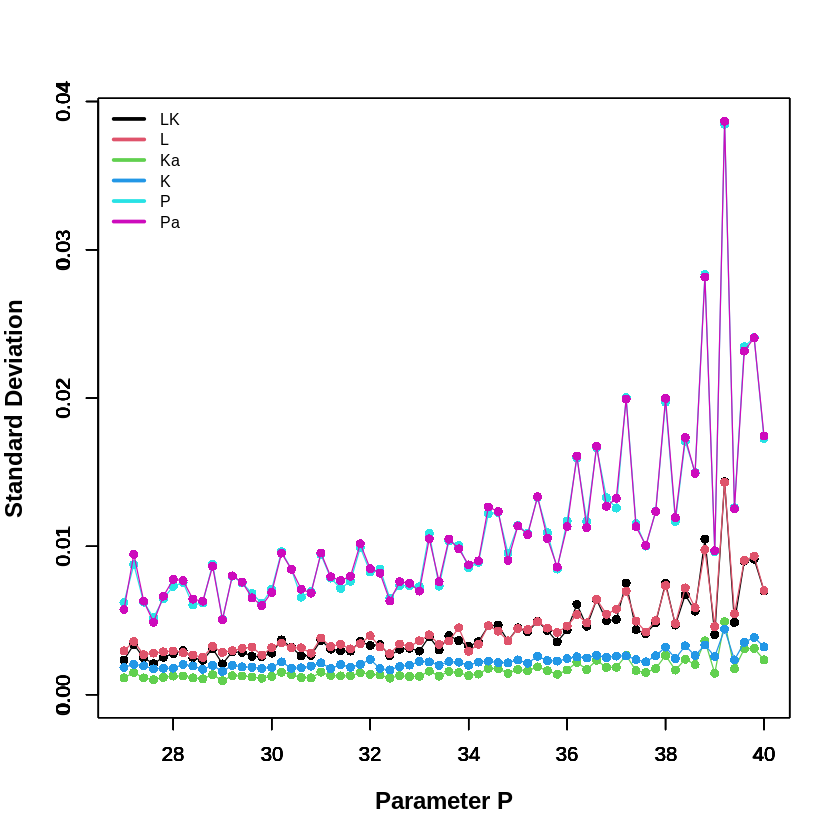

In [83]:
#@title graficar las desviaciones estándar
plot(Stimulus,auxSD[,2],type="o",pch=16,col=1,ylim = c(0,max(auxSD[,7])),xlab = "",ylab = "")
par(new=T)
plot(Stimulus,auxSD[,3],type="o",pch=16,col=2,ylim = c(0,max(auxSD[,7])),xlab = "",ylab = "")
par(new=T)
plot(Stimulus,auxSD[,4],type="o",pch=16,col=3,ylim = c(0,max(auxSD[,7])),xlab = "",ylab = "")
par(new=T)
plot(Stimulus,auxSD[,5],type="o",pch=16,col=4,ylim = c(0,max(auxSD[,7])),xlab = "",ylab = "")
par(new=T)
plot(Stimulus,auxSD[,6],type="o",pch=16,col=5,ylim = c(0,max(auxSD[,7])),xlab = "",ylab = "")
par(new=T)
plot(Stimulus,auxSD[,7],type="o",pch=16,col=6,ylim = c(0,max(auxSD[,7])),xlab = "Parameter P",
    ylab = "Standard Deviation",cex.lab=1.2,cex.axis=1.05,font.lab=2)
legend("topleft", legend=c("LK", "L", "Ka", "K","P","Pa"),
       col=c(1,2,3,4,5,6), lty=1,cex=0.8,lwd = 3, bty = "n")

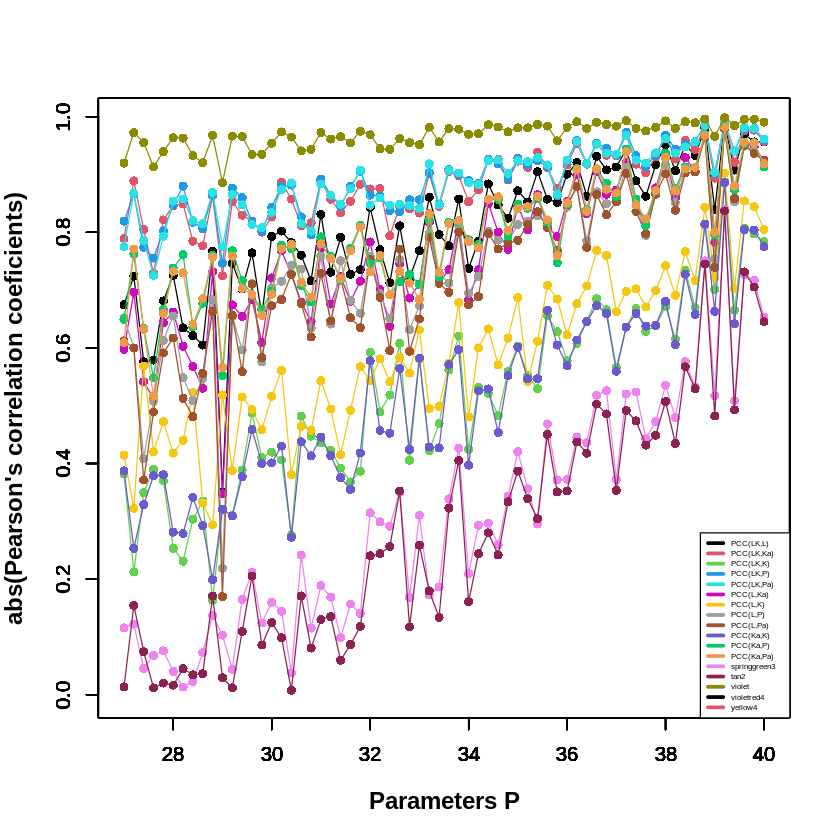

In [84]:
#@title graficar coeficientes de correlación
plot(Stimulus,abs(auxCOR[,1]),type="o",pch=16,col=1,ylim = c(0,max(auxCOR)),xlab = "",ylab = "")
par(new=T)
plot(Stimulus,abs(auxCOR[,2]),type="o",pch=16,col=2,ylim = c(0,max(auxCOR)),xlab = "",ylab = "")
par(new=T)
plot(Stimulus,abs(auxCOR[,3]),type="o",pch=16,col=3,ylim = c(0,max(auxCOR)),xlab = "",ylab = "")
par(new=T)
plot(Stimulus,abs(auxCOR[,4]),type="o",pch=16,col=4,ylim = c(0,max(auxCOR)),xlab = "",ylab = "")
par(new=T)
plot(Stimulus,abs(auxCOR[,5]),type="o",pch=16,col=5,ylim = c(0,max(auxCOR)),xlab = "",ylab = "")
par(new=T)
plot(Stimulus,abs(auxCOR[,6]),type="o",pch=16,col=6,ylim = c(0,max(auxCOR)),xlab = "",ylab = "")
par(new=T)
plot(Stimulus,abs(auxCOR[,7]),type="o",pch=16,col=7,ylim = c(0,max(auxCOR)),xlab = "",ylab = "")
par(new=T)
plot(Stimulus,abs(auxCOR[,8]),type="o",pch=16,col=8,ylim = c(0,max(auxCOR)),xlab = "",ylab = "")
par(new=T)
colors <- c("sienna", "slateblue", "springgreen3", "tan2", "violet", "violetred4", "yellow4")
plot(Stimulus,abs(auxCOR[,9]),type="o",pch=16,col=colors[1],ylim = c(0,max(auxCOR)),xlab = "",ylab = "")
par(new=T)
plot(Stimulus,abs(auxCOR[,10]),type="o",pch=16,col=colors[2],ylim = c(0,max(auxCOR)),xlab = "",ylab = "")
par(new=T)
plot(Stimulus,abs(auxCOR[,11]),type="o",pch=16,col=colors[3],ylim = c(0,max(auxCOR)),xlab = "",ylab = "")
par(new=T)
plot(Stimulus,abs(auxCOR[,12]),type="o",pch=16,col=colors[4],ylim = c(0,max(auxCOR)),xlab = "",ylab = "")
par(new=T)
plot(Stimulus,abs(auxCOR[,13]),type="o",pch=16,col=colors[5],ylim = c(0,max(auxCOR)),xlab = "",ylab = "")
par(new=T)
plot(Stimulus,abs(auxCOR[,14]),type="o",pch=16,col=colors[6],ylim = c(0,max(auxCOR)),xlab = "",ylab = "")
par(new=T)
plot(Stimulus,abs(auxCOR[,15]),type="o",pch=16,col=colors[7],ylim = c(0,max(auxCOR)),xlab = "Parameters P",
     ylab = "abs(Pearson's correlation coeficients)",cex.lab=1.2,cex.axis=1.05,font.lab=2)
legend("bottomright", legend=c("PCC(LK,L)", "PCC(LK,Ka)", "PCC(LK,K)", "PCC(LK,P)", "PCC(LK,Pa)","PCC(L,Ka)",
                          "PCC(L,K)","PCC(L,P)","PCC(L,Pa)","PCC(Ka,K)","PCC(Ka,P)","PCC(Ka,Pa)",
                        "springgreen3","tan2","violet","violetred4","yellow4"), 
       lty=1,lwd = 3,cex=0.4, col = c(seq(1,8), colors))

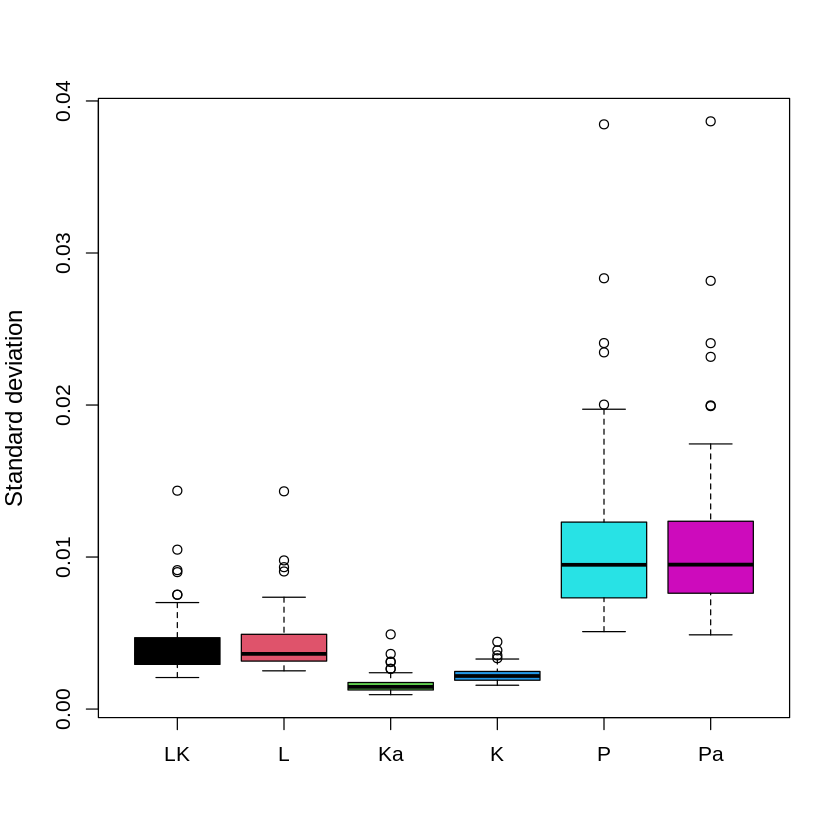

In [85]:
# Boxplot
colores <- c(1,2,3,4,5,6)
variables <- c("LK", "L", "Ka", "K","P","Pa")
boxplot(auxSD[,2], auxSD[,3], auxSD[,4], auxSD[,5], auxSD[,6], auxSD[,7], col = colores,
        ylab = "Standard deviation", names = variables, horizontal = F,
        outline = T, boxwax = 0.2, cex.lab = 1.2, cex.axis = 1.05, font.lab = 2)

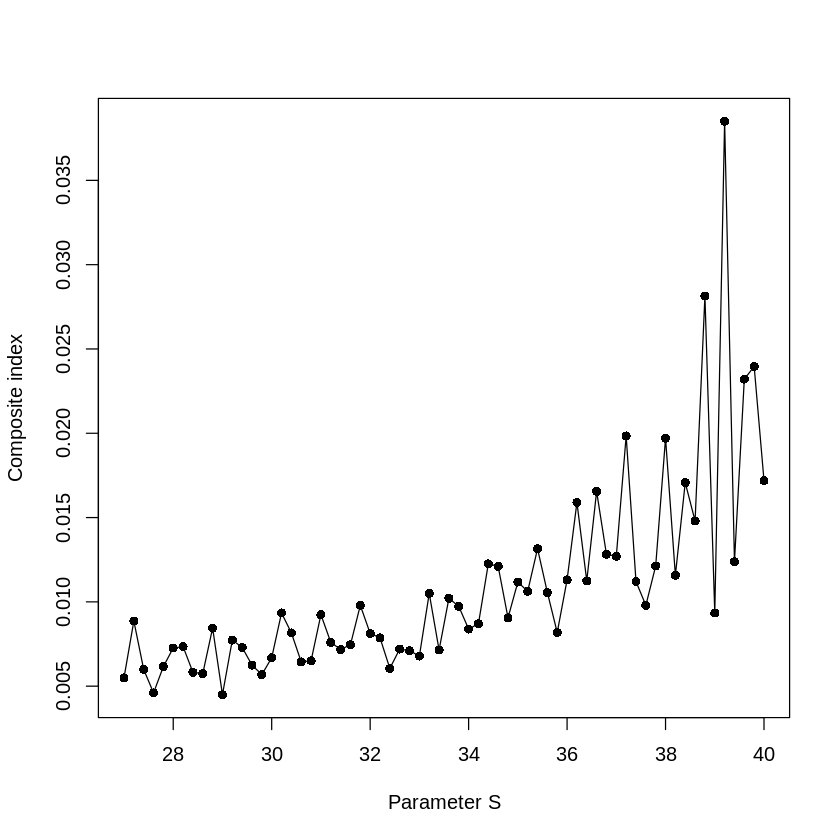

In [86]:
# índice compuesto
#plot(Stimulus,auxMarkers[,4],type="o",pch=16,col=1,xlab = "Parameter S",ylab = "Composite index")
  #Normalized plot -> compindex = SD*PCCd 
plot(Stimulus,auxMarkers[,4]*auxMarkers[,3],type="o",pch=16,col=1,xlab = "Parameter S",ylab = "Composite index")
legend(.3,35, legend=c("Composite index"),cex=0.8,pch=16,lty=1)

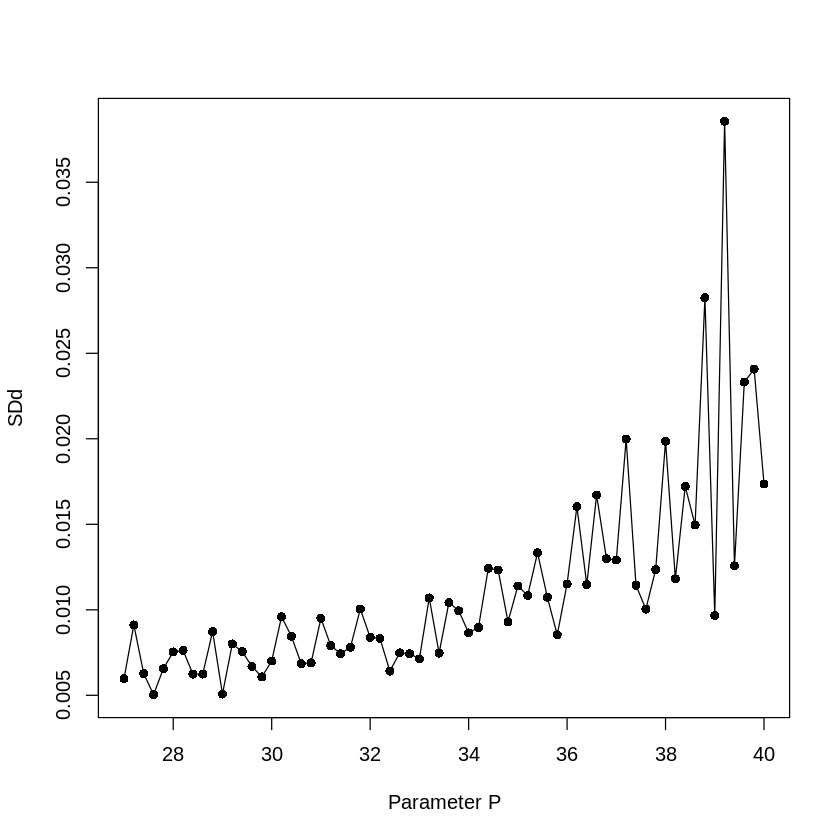

In [87]:
#SDd
plot(Stimulus,auxMarkers[,1],type="o",pch=16,col=1,xlab = "Parameter P",ylab = "SDd")

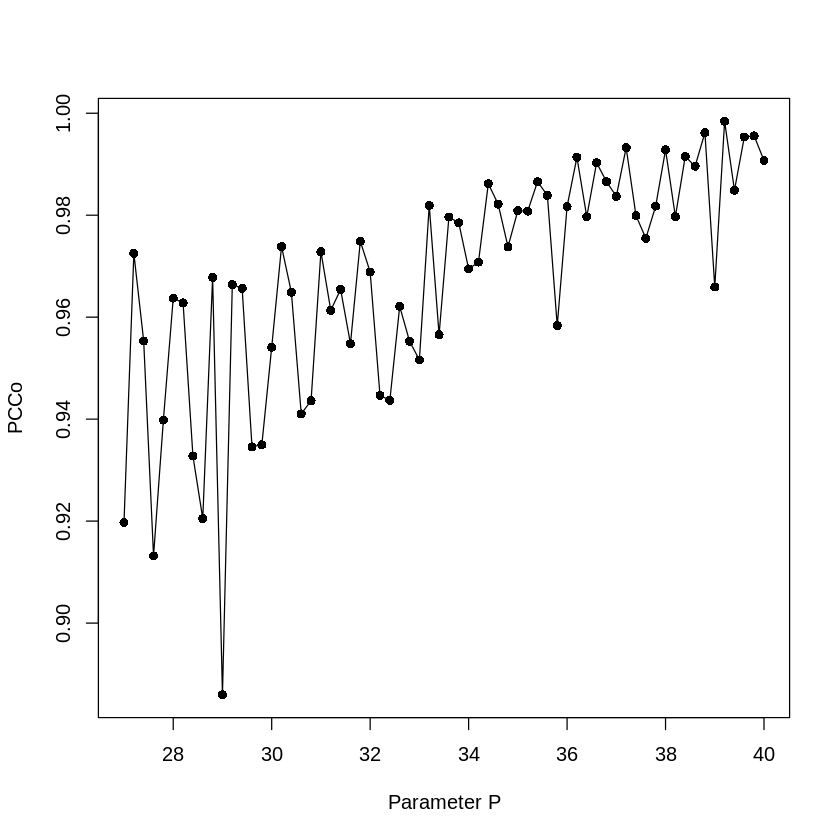

In [88]:
#PCCo
plot(Stimulus,auxMarkers[,2],type="o",pch=16,col=1,xlab = "Parameter P",ylab = "PCCo")

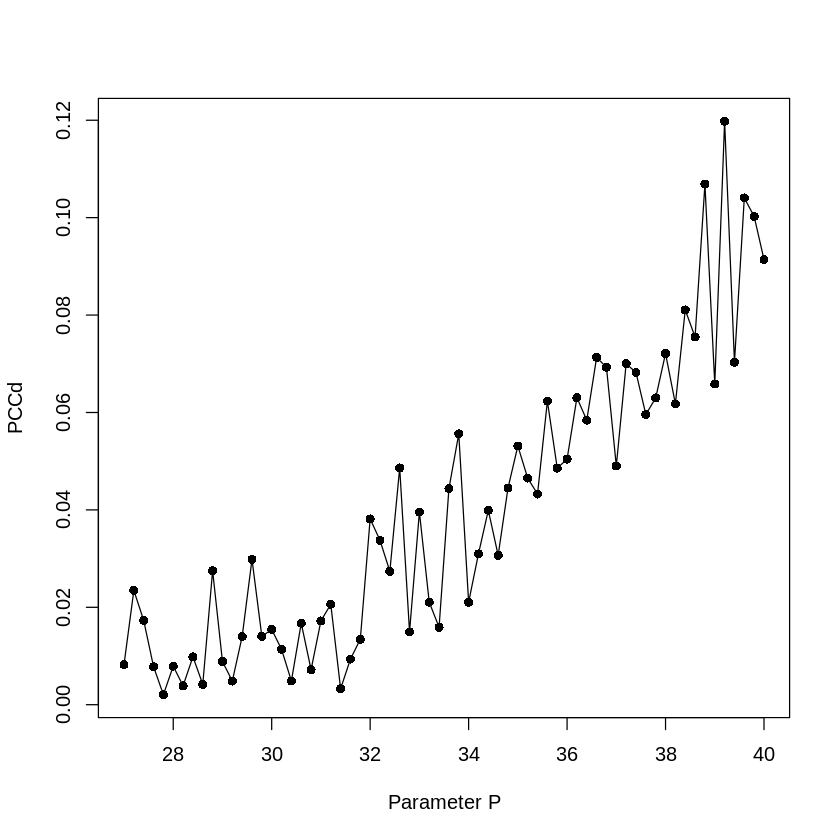

In [89]:
#PCCd
plot(Stimulus,auxMarkers[,3],type="o",pch=16,col=1,xlab = "Parameter P",ylab = "PCCd")